In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

from keras.applications import Xception

conv_base = Xception(weights='imagenet',
                  include_top=False,
                  input_shape=(150,150,3))

Using TensorFlow backend.


83689472/83683744 [==============================] - 10s 0us/step


In [2]:
conv_base.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 74, 74, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 74, 74, 32)   0           block1_conv1_bn[0][0]            
__________________________________________________________________________________________________
block1_con

In [3]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(512,activation='relu'))
model.add(layers.Dense(133,activation='softmax'))

In [4]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 5, 5, 2048)        20861480  
_________________________________________________________________
flatten_1 (Flatten)          (None, 51200)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               26214912  
_________________________________________________________________
dense_2 (Dense)              (None, 133)               68229     
Total params: 47,144,621
Trainable params: 47,090,093
Non-trainable params: 54,528
_________________________________________________________________


In [5]:
conv_base.trainable = False

In [6]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

base_dir = './dogImages'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'valid')
test_dir = os.path.join(base_dir, 'test')

In [7]:
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='categorical')

validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='categorical')

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

Found 6680 images belonging to 133 classes.
Found 835 images belonging to 133 classes.


In [10]:
from keras.callbacks import ModelCheckpoint 
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

checkpointer = ModelCheckpoint(filepath='dogsImages.pretrained.augmentation.model.weights.best.hdf5', 
                               verbose=1, 
                               save_best_only=True)
history = model.fit_generator(
      train_generator,
      steps_per_epoch=334,
      epochs=10,
      validation_data=validation_generator,
      validation_steps=42, 
      callbacks=[checkpointer], 
      verbose=2)


Epoch 1/10
 - 314s - loss: 2.1192 - acc: 0.4789 - val_loss: 1.9958 - val_acc: 0.6263

Epoch 00001: val_loss improved from inf to 1.99578, saving model to dogsImages.pretrained.augmentation.model.weights.best.hdf5
Epoch 2/10
 - 306s - loss: 2.0907 - acc: 0.4769 - val_loss: 2.0520 - val_acc: 0.6395

Epoch 00002: val_loss did not improve from 1.99578
Epoch 3/10
 - 311s - loss: 2.0546 - acc: 0.4912 - val_loss: 2.0798 - val_acc: 0.6551

Epoch 00003: val_loss did not improve from 1.99578
Epoch 4/10
 - 306s - loss: 2.0170 - acc: 0.5090 - val_loss: 2.0318 - val_acc: 0.6395

Epoch 00004: val_loss did not improve from 1.99578
Epoch 5/10
 - 331s - loss: 1.9317 - acc: 0.5160 - val_loss: 2.0676 - val_acc: 0.6539

Epoch 00005: val_loss did not improve from 1.99578
Epoch 6/10
 - 309s - loss: 1.9595 - acc: 0.5148 - val_loss: 2.0326 - val_acc: 0.6527

Epoch 00006: val_loss did not improve from 1.99578
Epoch 7/10
 - 309s - loss: 1.9409 - acc: 0.5156 - val_loss: 1.9975 - val_acc: 0.6455

Epoch 00007: val

In [11]:
model.load_weights('dogsImages.pretrained.augmentation.model.weights.best.hdf5')

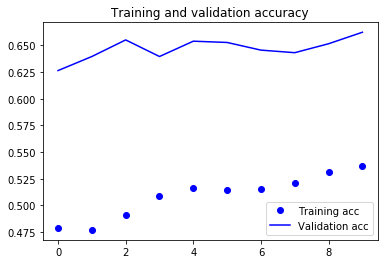

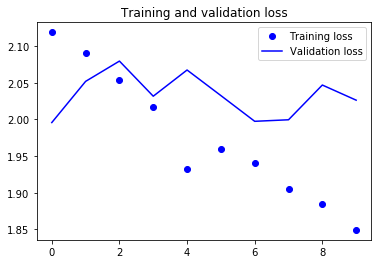

In [13]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [14]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block14_sepconv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [15]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

In [16]:
from keras.callbacks import ModelCheckpoint 
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

checkpointer = ModelCheckpoint(filepath='dogsImages.pretrained.finetuning.augmentation.model.weights.best.hdf5', 
                               verbose=1, 
                               save_best_only=True)
history = model.fit_generator(
      train_generator,
      steps_per_epoch=334,
      epochs=15,
      validation_data=validation_generator,
      validation_steps=42, 
      callbacks=[checkpointer], 
      verbose=2)

Epoch 1/15
 - 318s - loss: 2.0604 - acc: 0.4796 - val_loss: 1.7865 - val_acc: 0.5497

Epoch 00001: val_loss improved from inf to 1.78650, saving model to dogsImages.pretrained.finetuning.augmentation.model.weights.best.hdf5
Epoch 2/15
 - 308s - loss: 1.8977 - acc: 0.5150 - val_loss: 1.7939 - val_acc: 0.5725

Epoch 00002: val_loss did not improve from 1.78650
Epoch 3/15
 - 308s - loss: 1.8400 - acc: 0.5237 - val_loss: 1.7212 - val_acc: 0.5581

Epoch 00003: val_loss improved from 1.78650 to 1.72122, saving model to dogsImages.pretrained.finetuning.augmentation.model.weights.best.hdf5
Epoch 4/15
 - 308s - loss: 1.7480 - acc: 0.5385 - val_loss: 1.6924 - val_acc: 0.5749

Epoch 00004: val_loss improved from 1.72122 to 1.69240, saving model to dogsImages.pretrained.finetuning.augmentation.model.weights.best.hdf5
Epoch 5/15
 - 308s - loss: 1.7202 - acc: 0.5442 - val_loss: 1.6673 - val_acc: 0.5737

Epoch 00005: val_loss improved from 1.69240 to 1.66735, saving model to dogsImages.pretrained.fin

In [17]:
model.load_weights('dogsImages.pretrained.finetuning.augmentation.model.weights.best.hdf5')

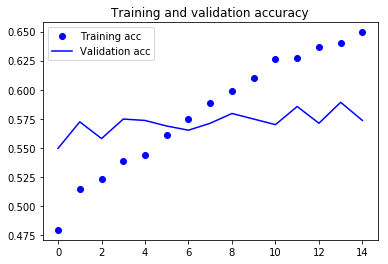

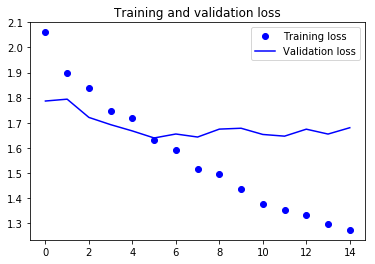

In [18]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

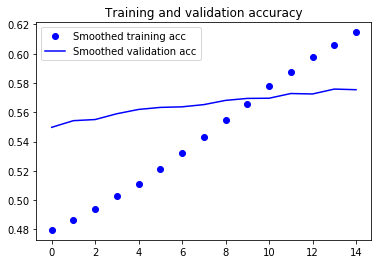

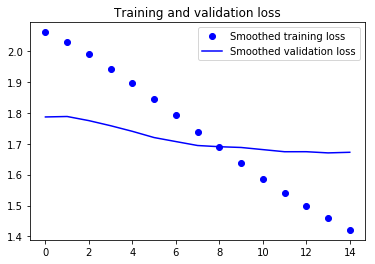

In [19]:
def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous*factor+point*(1-factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

plt.plot(epochs, smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs, smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs, smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [20]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='categorical')

test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print("test_acc:",test_acc)

Found 836 images belonging to 133 classes.
test_acc: 0.5833333341711496
